# Определение возраста покупателей

## Исследовательский анализ данных

**Описание проекта**


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Сделаю необходимый импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

Загружаю датасет и смотрю на размер

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.shape

(7591, 2)

Для наглядности посмотрим на распределение возрастов

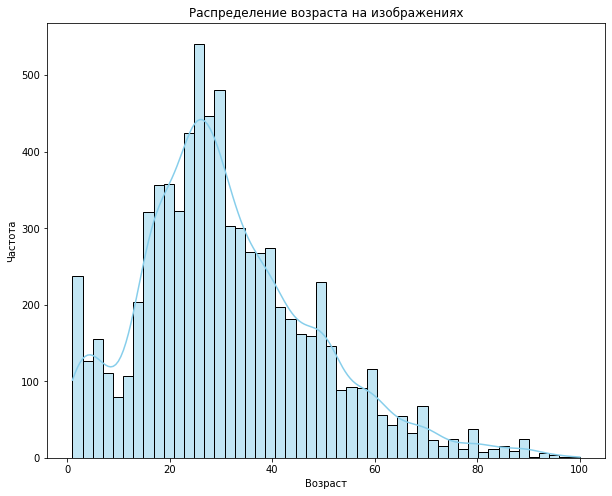

In [13]:
plt.figure(figsize=(10, 8))
sns.histplot(data['real_age'], bins=50, kde=True, color='skyblue')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста на изображениях')
plt.show()

На мой взгляд распределение неплохое, однако возможно будет труднее определять точный возраст людей за 60

Загрузим изображения

In [8]:
train_ID = ImageDataGenerator(rescale=1./255)
train = train_ID.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [9]:
features,target=next(train)

In [16]:
images = []
for i in range(len(features)):
    images.append(features[i])




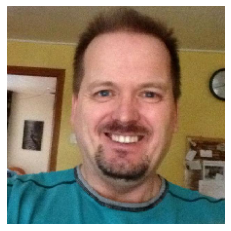

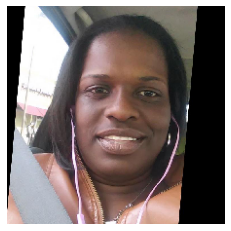

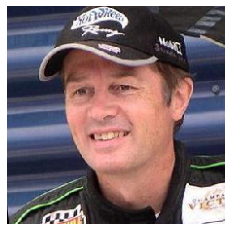

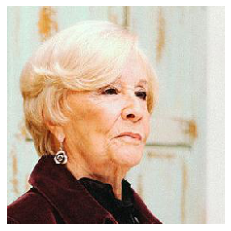

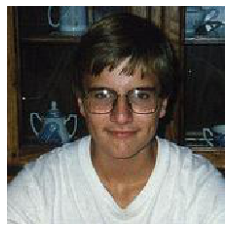

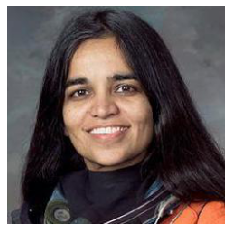

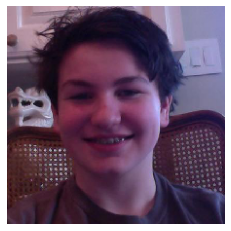

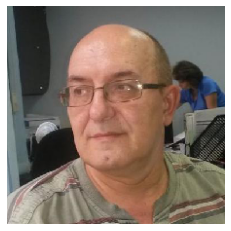

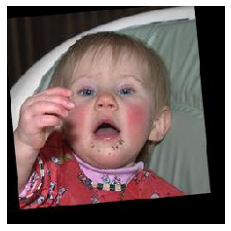

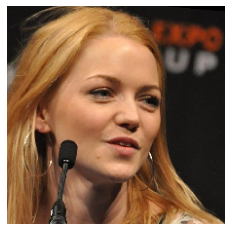

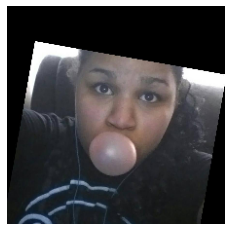

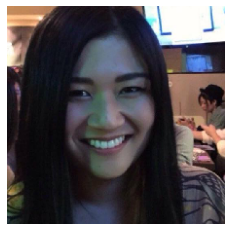

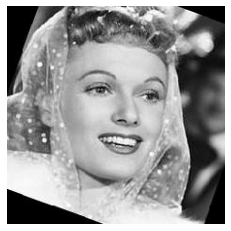

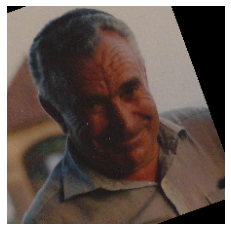

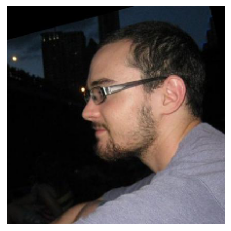

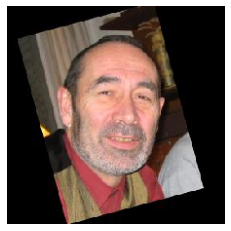

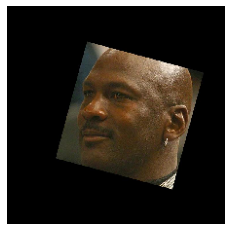

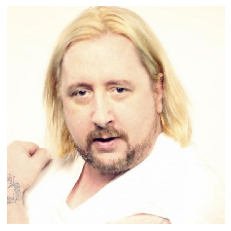

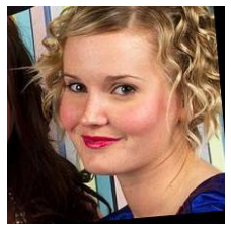

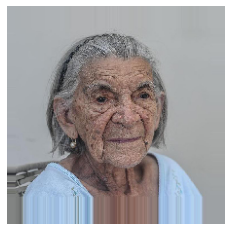

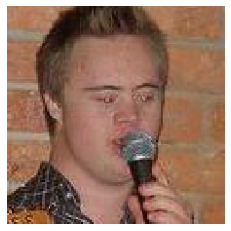

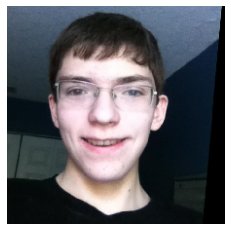

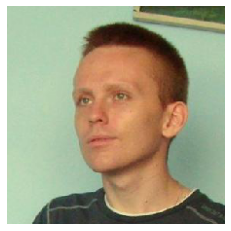

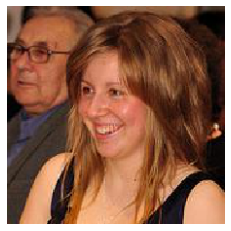

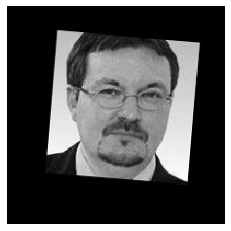

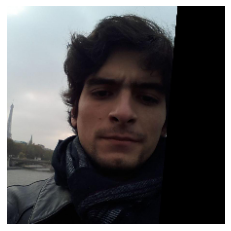

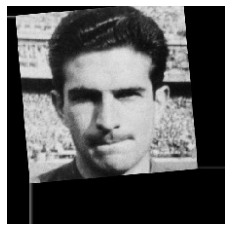

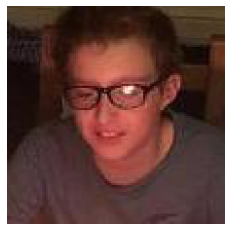

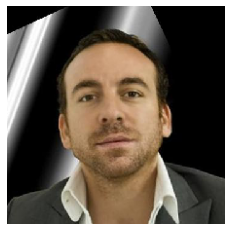

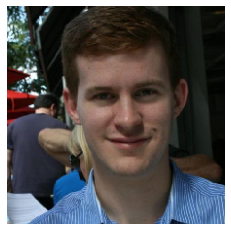

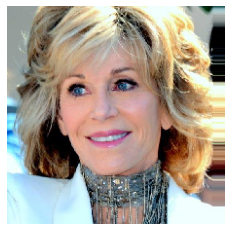

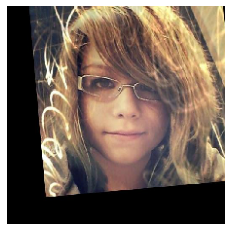

In [17]:
for img in images:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Данные готовы к работе, можно строить нейронную сеть

**Вывод**

Мы имеем небольшой датасет, в теории его все равно может хватить, но только людей за 60 все-таки намного меньше.
Я проведу дополнительный тест модели с аугментацией

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


def load_train(path):

    data = pd.read_csv(path + 'labels.csv')

    train_ID = ImageDataGenerator( rescale=1./255, validation_split=0.2 )

    train = train_ID.flow_from_dataframe(
          dataframe=data,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345) 

    return train

def load_test(path):

    data = pd.read_csv(path + 'labels.csv')

    test_ID = ImageDataGenerator( rescale=1./255, validation_split=0.2 )

    test = test_ID.flow_from_dataframe(
          dataframe=data,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='validation',
          seed=12345) 

    return test

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


    return model

def train_model( model, train_datagen_flow, test_data_flow, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None ):
  
  

    model.fit(
      train_datagen_flow,
      validation_data=test_data_flow,
      epochs=epochs,
      steps_per_epoch=len(train_datagen_flow),
      validation_steps=len(test_data_flow) ,
      verbose=2,
      shuffle=True
  )


    return model

```

```

# <  результат вывода на экран сюда >


Train for 190 steps, validate for 48 steps
Epoch 1/15
2023-10-06 20:02:43.593010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-06 20:02:44.011601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 54s - loss: 246.1790 - mae: 11.2014 - val_loss: 878.9205 - val_mae: 24.6412
Epoch 2/15
190/190 - 44s - loss: 65.1475 - mae: 6.1718 - val_loss: 571.9557 - val_mae: 18.5205
Epoch 3/15
190/190 - 44s - loss: 33.2520 - mae: 4.3848 - val_loss: 388.0450 - val_mae: 14.5054
Epoch 4/15
190/190 - 44s - loss: 20.3053 - mae: 3.5134 - val_loss: 115.5677 - val_mae: 8.0727
Epoch 5/15
190/190 - 41s - loss: 15.2837 - mae: 3.0690 - val_loss: 87.5347 - val_mae: 7.0704
Epoch 6/15
190/190 - 40s - loss: 12.9433 - mae: 2.8085 - val_loss: 65.1882 - val_mae: 6.1155
Epoch 7/15
190/190 - 40s - loss: 10.9881 - mae: 2.5468 - val_loss: 68.5410 - val_mae: 6.1897
Epoch 8/15
190/190 - 40s - loss: 10.2954 - mae: 2.4235 - val_loss: 65.9094 - val_mae: 5.9926
Epoch 9/15
190/190 - 39s - loss: 9.3745 - mae: 2.3134 - val_loss: 63.9720 - val_mae: 6.1152
Epoch 10/15
190/190 - 38s - loss: 7.2122 - mae: 2.0499 - val_loss: 70.3582 - val_mae: 6.2642
Epoch 11/15
190/190 - 40s - loss: 6.0665 - mae: 1.8605 - val_loss: 66.0701 - val_mae: 6.2568
Epoch 12/15
190/190 - 49s - loss: 6.1662 - mae: 1.8840 - val_loss: 61.4302 - val_mae: 5.8832
Epoch 13/15
190/190 - 53s - loss: 6.0362 - mae: 1.8611 - val_loss: 64.7519 - val_mae: 5.9716
Epoch 14/15
190/190 - 52s - loss: 6.2596 - mae: 1.8598 - val_loss: 73.7025 - val_mae: 6.7013
Epoch 15/15
190/190 - 50s - loss: 5.7852 - mae: 1.7989 - val_loss: 60.2127 - val_mae: 5.8253
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 60.2127 - mae: 5.8253
Test MAE: 5.8253
```

## Анализ обученной модели

**Итог**

Я построил сеть используя:
- Оптимизацию Adam, тк она автоматический подбирает шаг градиента
- Использовал популряную архитектуру ResNet50
- В качестве функции потерь использовал mse, тк это может положительно сказаться на скорости обучения 
- Как говорилось в задании, метрика была выбрана mae, удолетворяя условию, она состаляеет менее 8
- Функция акцивации на последнем слое - relu, тк задача регрессии и у нас не может быть отрицательных значений
